In [95]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
from PIL import Image
import random
from matplotlib.pyplot import figure
import glob
import pytesseract
import re
import easyocr
import math
from scipy import ndimage
pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR/tesseract.exe'
reader=easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [96]:
#Load Yolo v4 on custom trained weights
weights='yolov4_train_last.weights'
configuration='yolov4_train.cfg'
yolov4 = cv2.dnn.readNet(weights,configuration)

In [159]:
classes=['Vehicle registration plate']

In [136]:
def find_alignment_angle(image):
    median_angle=0
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)
    
    angles = []
    try:
        
        for [[x1, y1, x2, y2]] in lines:
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            angles.append(angle)
            
        median_angle = np.median(angles)
        print(median_angle)
    except:
        pass
    return median_angle

In [158]:
def lst_str(lst):
    str1 = "" 
    for ele in lst: 
        str1 += ele  
    return str1 

In [163]:
# function for detect objects from images
crop_img=[]
def detect_object(url,shape=(20,10),accu_score=0.6,box_width=2,text_size=2 , ocr_vs_tess=False):
  img = Image.open(url)
  img=np.asarray(img)
  height, width, channels = img.shape
  blob = cv2.dnn.blobFromImage(img, 1/255 , (416 , 416) ,(0,0,0) , swapRB=True , crop=False)
  yolov4.setInput(blob)
  output_layer_name=yolov4.getUnconnectedOutLayersNames()
  layeroutput=yolov4.forward(output_layer_name)

  boxes=[]
  confidences=[]
  class_ids=[]
  for output in layeroutput:
    for detection in output:
      score=detection[5:]
      class_id=np.argmax(detection[5:])
      confidence=score[class_id]
      if confidence >accu_score:
        center_x=int(detection[0]*width)
        center_y=int(detection[1]*height)
        w=int(detection[2]*width)
        h=int(detection[3]*height)

        x=int(center_x-w/2)
        y=int(center_y-h/2)

        boxes.append([x,y,w,h])
        confidences.append(float(confidence))
        class_ids.append(class_id)
  print(len(boxes))
  indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)


  font = cv2.FONT_HERSHEY_PLAIN
  colors=[random.uniform(0,255) for i in range(len(boxes))]
  crop_img=[]
  for i in range(len(boxes)):
      if i in indexes:
          x, y, w, h = boxes[i]
  
          label = str(classes[class_ids[i]])
          color = colors[i]
          confi=str(round(confidences[i],2))
  
          cv2.rectangle(img, (x,y), (x + w, y + h), color, box_width)
          cv2.putText(img, label+ " "+confi, (x, y + 0), font, 2, color,text_size)
        
          crop_img.append(img[y:y+h, x:x+w])
  print(f'No of object detected = {len(indexes)}')
  figure(num=None,figsize=shape) 
  plt.imshow(img)
  plt.show()
  for i in crop_img:
    angle=find_alignment_angle(i)
    
    if ocr_vs_tess:
        plt.imshow(i)
        plt.show() 
        ocr_vs_tessaract(ndimage.rotate(i, angle))
    else:   
        print(reader.readtext(i, detail = 0 , paragraph=True))
        plt.imshow(i)
        plt.show() 
        print(reader.readtext(i, detail = 0 , paragraph=True))
        plt.imshow(ndimage.rotate(i, angle))
        plt.show()
    
    

In [169]:
def ocr_vs_tessaract(img):
    tess=""
    easy=""
    print('without preprocess :-')
    temp=pytesseract.image_to_string(img, config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    print(f' tesseract => {temp}')
    print(f'easyocr    => {lst_str(reader.readtext(img, detail = 0))}')
    print(getSkewAngle(img))
    img=cv2.resize(img,None , fx=3,fy=3,interpolation=cv2.INTER_CUBIC)
    img=cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    img=cv2.GaussianBlur(img , (5,5) , 0)
    ret , thresh=cv2.threshold(img , 0,255,cv2.THRESH_OTSU |  cv2.THRESH_BINARY_INV)
    rectangular_kernal = cv2.getStructuringElement(cv2.MORPH_RECT ,(5,5))
    dialation=cv2.dilate(thresh , rectangular_kernal , iterations=1)
    
    plt.imshow(dialation , cmap='gray')
    plt.show()
    
    temp=pytesseract.image_to_string(img, config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    print('mid preprocess :-')
    print(f' tesseract => {temp}')
    print(f'easyocr    => {lst_str(reader.readtext(img, detail = 0))}')
    contours , hierarcy = cv2.findContours(dialation , cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours=sorted(contours , key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    for cnt in sorted_contours:
        x,y,w,h=cv2.boundingRect(cnt)
        height , width =img.shape
        
#         if height/float(h)>3:continue
        ratio=h/float(w)
        if ratio<1.5 :continue
#         if width/float(w)>15:continue
        area=h*w
        if area<100:continue
            
        roi=thresh[y-5 :y+h+5 , x-5 :x+w+5]
        roi=cv2.bitwise_not(roi)
        roi=cv2.medianBlur(roi, 5)
        text_temp= pytesseract.image_to_string(roi, config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
        clean_text=re.sub('[\W_]+' , '' , text_temp)
        tess=tess+clean_text
        easy=easy+ lst_str(reader.readtext(roi, detail = 0))
        
    print('preprocessed')
    print(f' tesseract => {tess}')
    print(f'easyocr    => {easy}')

In [170]:
# tessaract vs easyocr

2
No of object detected = 1


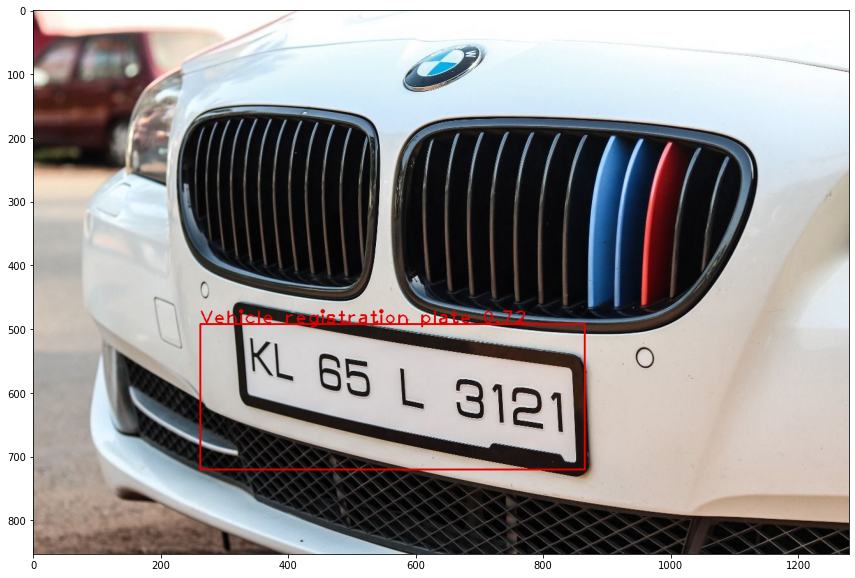

10.486588243289624


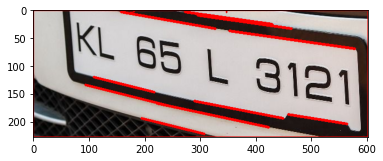

without preprocess :-
 tesseract => 
easyocr    => KL85L3121
((316.5, 166.5), (333.0, 633.0), 90.0)
None


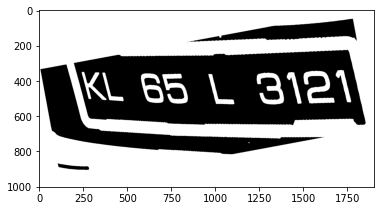

mid preprocess :-
 tesseract => 
easyocr    => KL85L 3121
preprocessed
 tesseract => 
easyocr    => 
2
No of object detected = 1


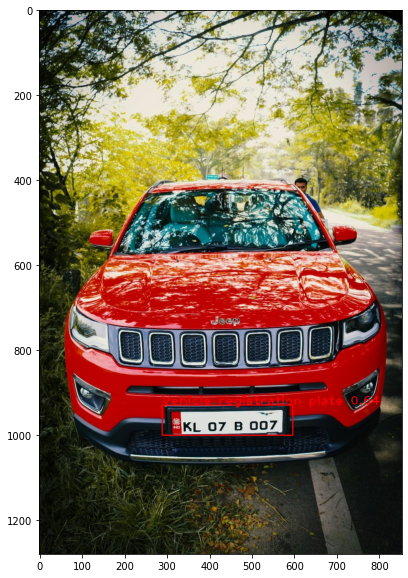

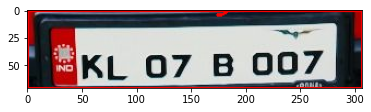

without preprocess :-
 tesseract => STS

easyocr    => KL 07B 007
((153.0, 35.0), (70.0, 306.0), 90.0)
None


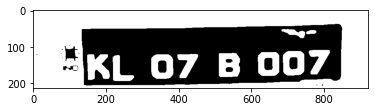

mid preprocess :-
 tesseract => M07B007M

easyocr    => INDKL07B 007
preprocessed
 tesseract => 
easyocr    => 
1
No of object detected = 1


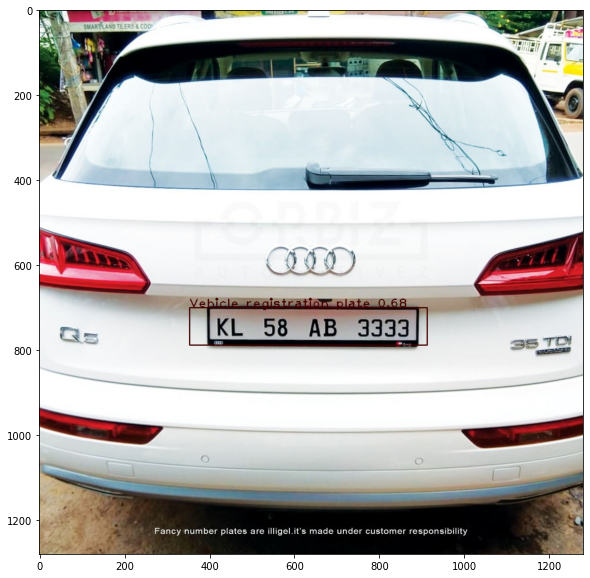

0.0


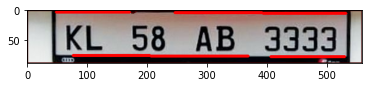

without preprocess :-
 tesseract => 1KL58AB3333

easyocr    => KL58AB3333 
((279.0, 43.5), (87.0, 558.0), 90.0)
None


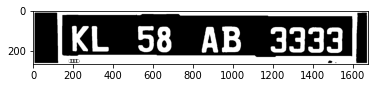

mid preprocess :-
 tesseract => 1KL58AB3333

easyocr    => KL58AB3333@D
preprocessed
 tesseract => PK58AA3333
easyocr    => K58A3333


In [171]:
files=glob.glob('IMAGE/*')
len(files)
for i in files[:3]:
    detect_object(i,ocr_vs_tess=True)

In [ ]:
# with easyocr

2
No of object detected = 1


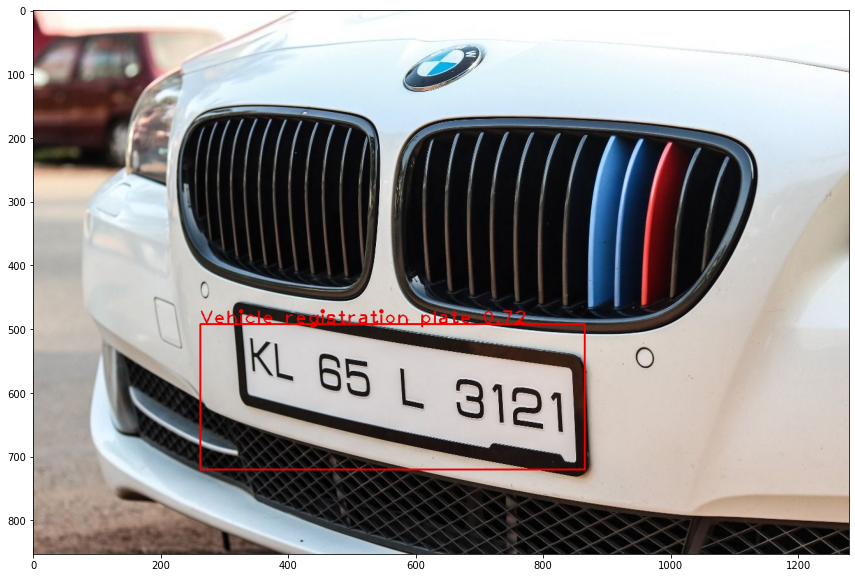

10.51742318354621
['KL 85 L 3121']


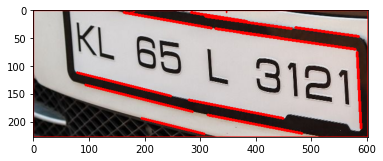

['KL 85 L 3121']


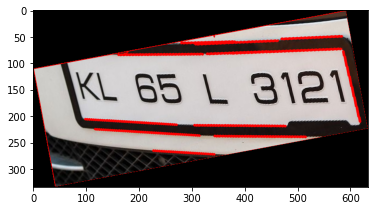

2
No of object detected = 1


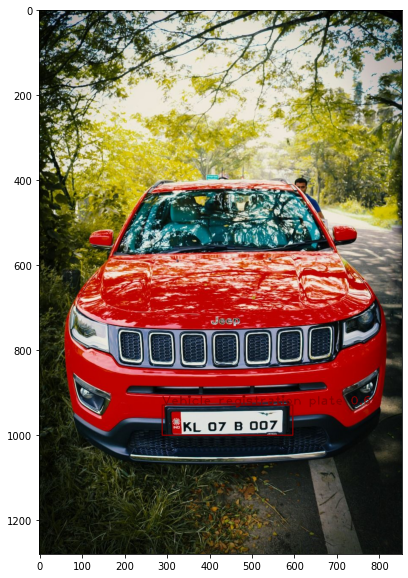

['KL 07 B 007']


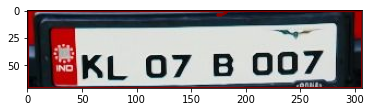

['KL 07 B 007']


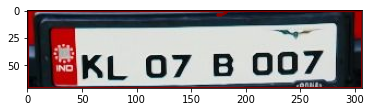

1
No of object detected = 1


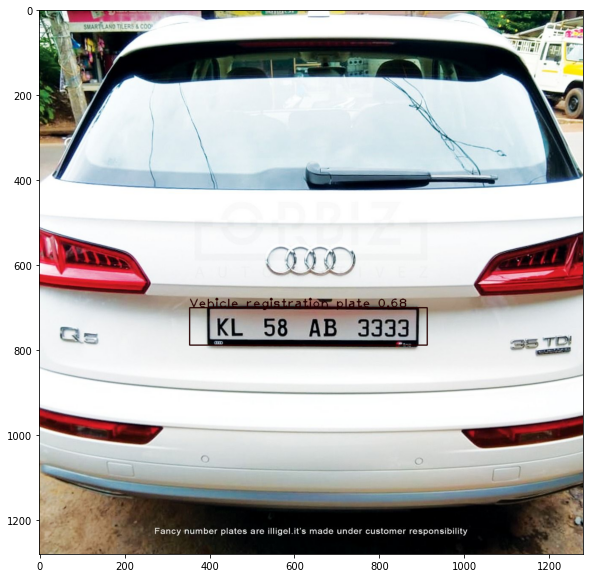

0.0
['KL 58 AB 3333 ']


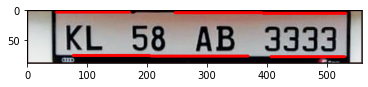

['KL 58 AB 3333 ']


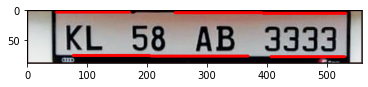

4
No of object detected = 1


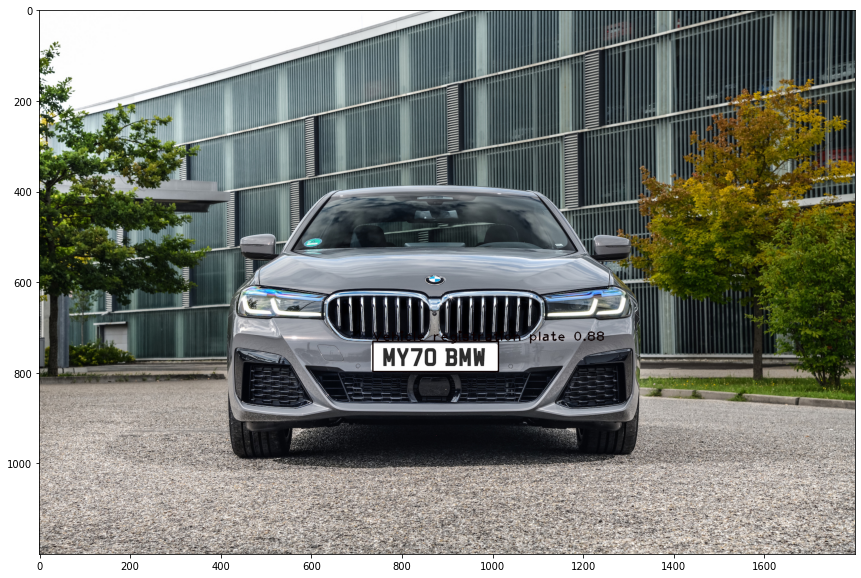

0.0
['MY7O BMW']


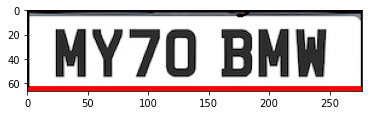

['MY7O BMW']


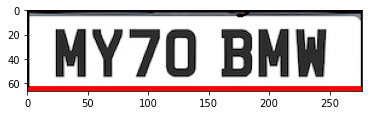

2
No of object detected = 1


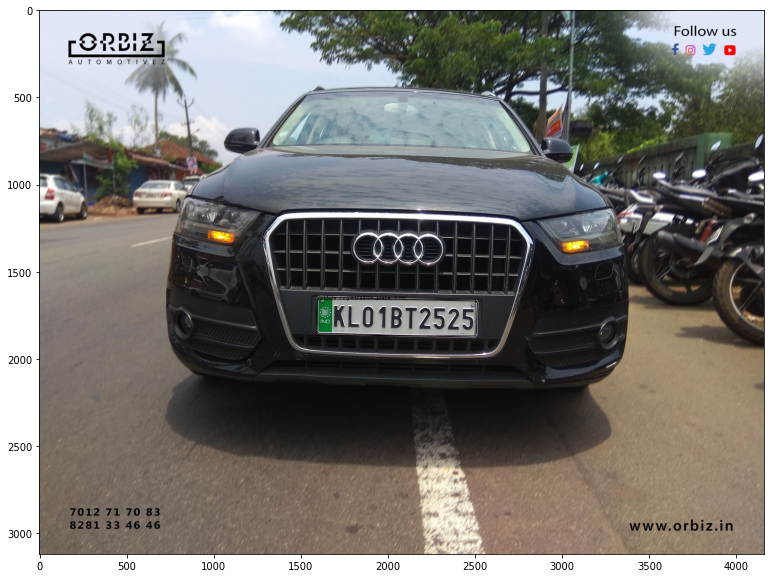

0.0
['IND', 'KLO 1BT2525']


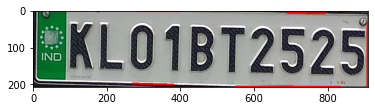

['IND', 'KLO 1BT2525']


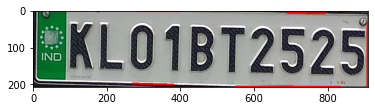

6
No of object detected = 2


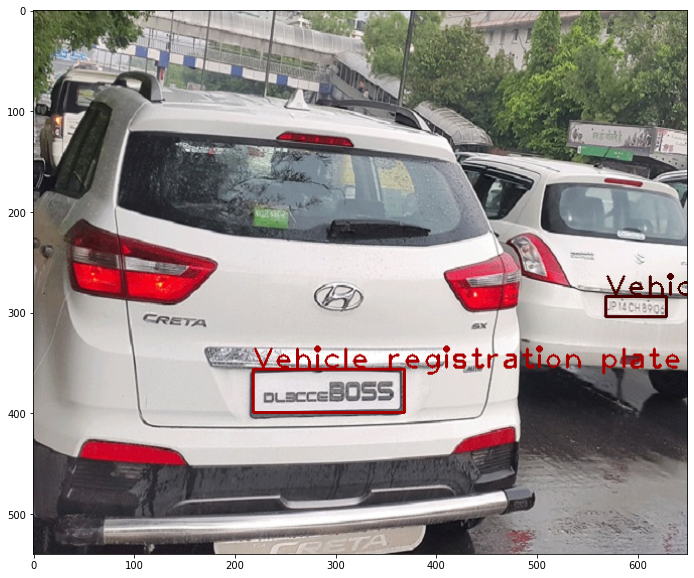

["'iddl"]


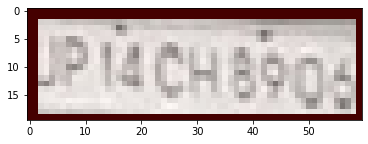

["'iddl"]


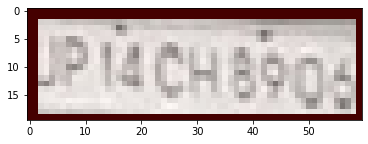

['DLSCCEBOSS']


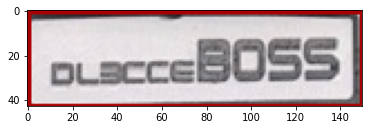

['DLSCCEBOSS']


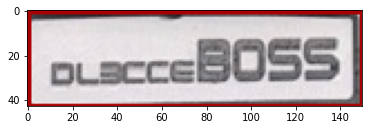

3
No of object detected = 1


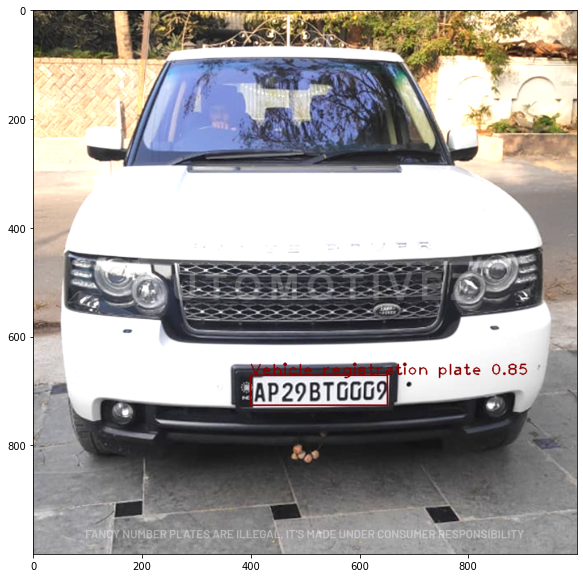

0.0
['AP22BTGG0A']


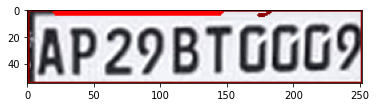

['AP22BTGG0A']


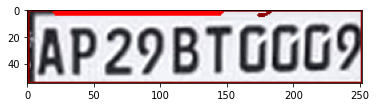

In [174]:
files=glob.glob('IMAGE/*')
len(files)
for i in files[:7]:
    detect_object(i,ocr_vs_tess=False)